## Creating Customer Segments

## Getting Started

In this project, I analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
import warnings
from IPython.display import display # Allows the use of display() for DataFrames
warnings.filterwarnings("ignore")

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration

the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. 

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. 

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9413,8259,5126,666,1795,1451
1,5531,15726,26870,2367,13726,446
2,7858,1110,1094,6818,49,287


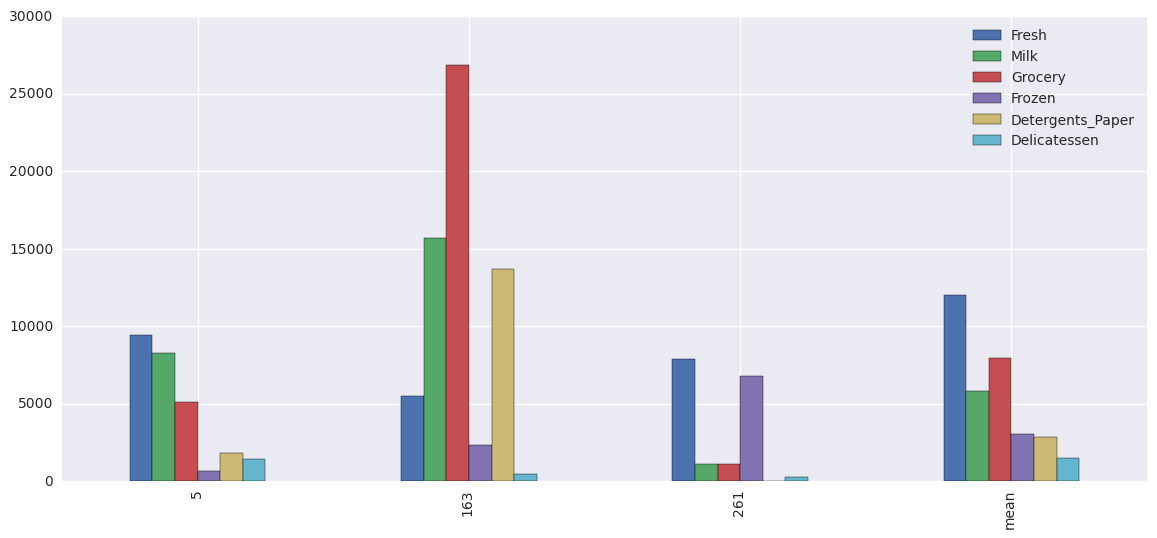

In [3]:
# Select three sample from the dataset
indices = [5,163,261]
# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)


import seaborn as sns
samples_bar = samples.append(data.describe().loc['mean'])
samples_bar.index = indices + ['mean']
_ = samples_bar.plot(kind='bar', figsize=(14,6))

**采样点0: 代表类型为超市。从数据中，我们可以看出, 该用户对六类商品的需求均超过统计数的75%, 说明对每类商品的需求量都较大，可以推测它应该是诸如沃尔玛之类的大型超市。    
采样点1：代表类型为零售商。从数据中可以看出，该用户对于Grocery和Detergents_Paper需求较多，而其他需求较少，其需求为日常用品。可以推测其为零售店。   
采样点2：代表类型为咖啡店。该类型对于Fresh和Frozen的需求较高，其中Frozen的需求很高，而对于Detergents_Paper和Delicatessen需求很低，我们可以推测这种类型可能为诸如星巴克之类的咖啡店。**

### Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? 
We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [4]:
from sklearn.cross_validation import train_test_split
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Detergents_Paper', axis = 1)

# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Detergents_Paper'], test_size  = .25, random_state = 5)

from sklearn import tree
#  Create a decision tree regressor and fit it to the training set
regressor = tree.DecisionTreeRegressor()
regressor.fit(X_train,y_train)

#  Report the score of the prediction using the testing set
print regressor.score(X_test,y_test)

0.77173991331


**我选择使用Datergents_Paper 这个特征去预测，预测的得分为0.66。R2得分的系数得分介于0-1之间，这个得分为中等相关，对于区分用户的消费习惯并不是必需的。**

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data.

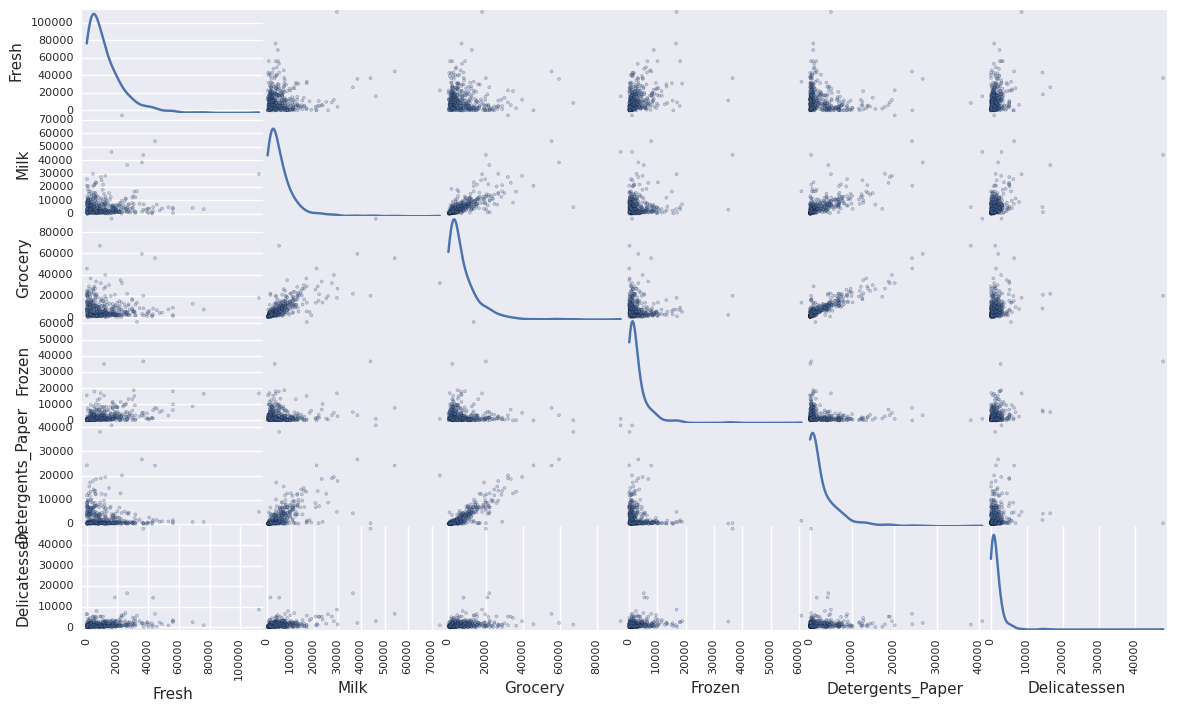

In [5]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

Detergents_Paper 和 Grocery 在一定程度上是相关的。其他的关联度不大。这验证了我关于数据不相关的预测.数据多集中在中位数以下,且增长率大致相同。   

## Data Preprocessing   数据的预处理
preprocess the data to create a better representation of customers by performing a scaling on the data and detecting and optionally removing outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Feature Scaling  特征缩放
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew)。
we Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.we Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log` also.

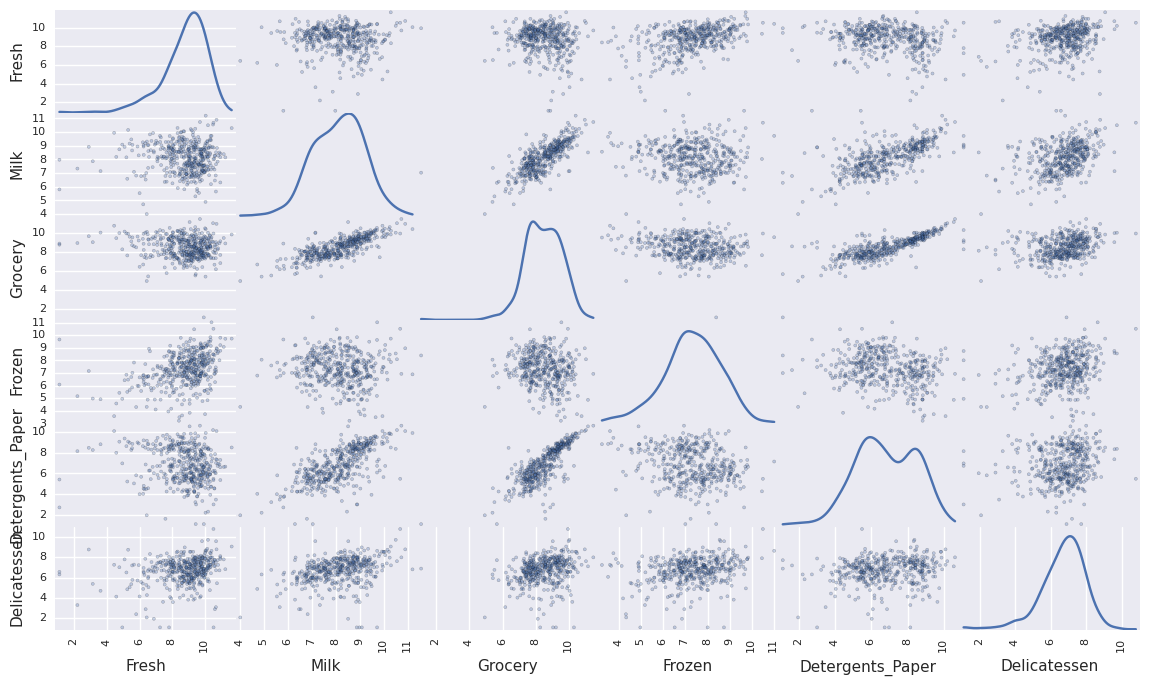

In [6]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [7]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.149847,9.019059,8.542081,6.501290,7.492760,7.280008
1,8.618124,9.663071,10.198766,7.769379,9.527047,6.100319
2,8.969287,7.012115,6.997596,8.827321,3.891820,5.659482


###  Outlier Detection

In [8]:
outliersDict = {}
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    outliersIndex =  data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index
    for i in outliersIndex:
        if i in outliersDict:
            outliersDict[i] += 1
        else:
            outliersDict[i] = 1
    
## Select the indices for data points you wish to remove
outliers = []
[outliers.append(i) for i in outliersDict if outliersDict[i] > 1]
print outliers

## Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


[128, 154, 65, 66, 75]


**从数据中我们可以看出，有5个数据项有多个特征为异常值，它们分别是128, 154, 65, 66, 75。这些值很明显的与正常值不同并且和总体数据的关联性也较小。所以将其从数据中删除。**

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

###  PCA

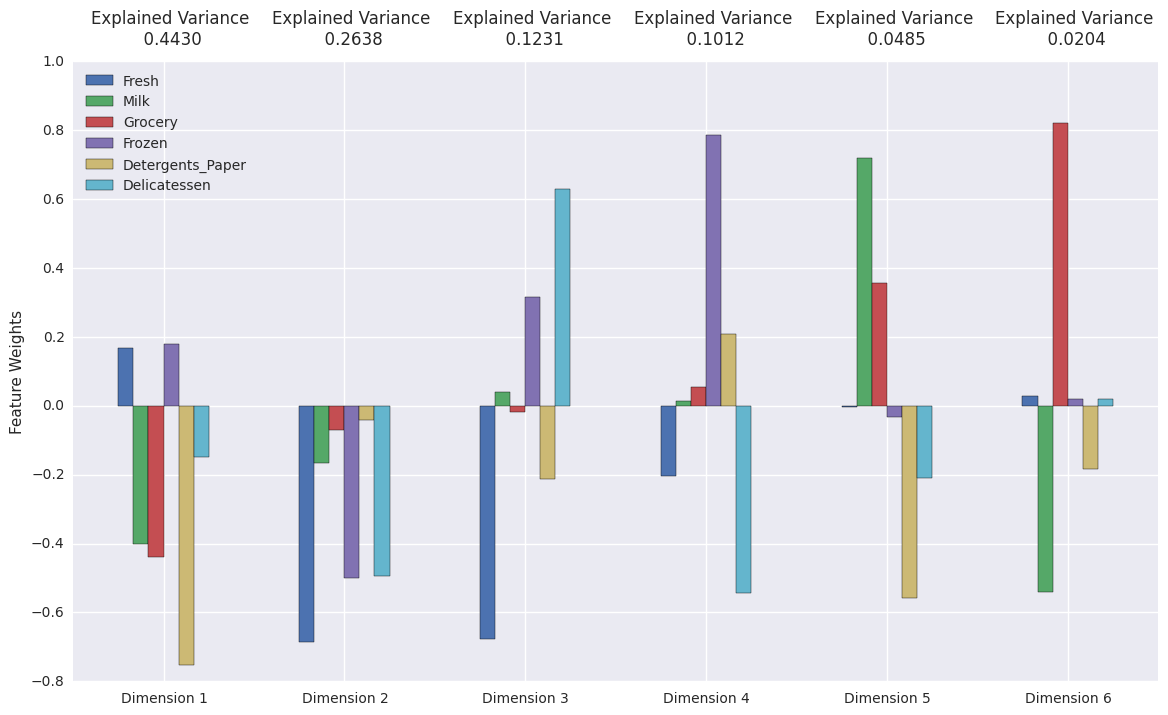

In [9]:
# Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components = 6)
pca.fit(good_data)

# Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

   **从图中我们可以看出来，前两个主成分组合的variance为0.4430+0.2638= 0.7068,前四个主成分variance的组合为0.4430+0.2638+0.1231+0.1012=0.9311**    
**
第一维度:Detergents_Paper有着一个很显注的正向权重，对milk和grocery都有着不错的正权重。这个维度的顾客看来十分着重零售商品的消费，可能是一间零售小店。    
第二维度：可以看出来，顾客对Fresh,Frozen,Delicatessen有着较大需求。各种产品均为正相关，而且Fresh,Frozen,Delicatessen三者权重较大。   
第三维度：用户需求Delicatessen，而对于不需要Fresh，对于Fresh 具有较大的负向权重。    
第四维度: 用户较多的需要Frozen，而不需要Delicatessen。从数据中可以看出。Frozen有较大的正向权重，而对于Delicatessen较大的负向权重。   **

### Observation
log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. 

In [10]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.0850,-0.3243,-0.2635,-0.8812,0.1862,-0.5347
1,-3.2843,-0.3226,-0.6824,1.3902,0.3089,0.0930
2,3.7303,0.0337,0.2849,0.9950,0.4662,-0.0506


### Dimensionality Reduction

In [11]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2)
pca.fit(good_data)
# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [12]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.0850,-0.3243
1,-3.2843,-0.3226
2,3.7303,0.0337


## Clustering

Use Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. 

K-means算法的聚类思想比较简单明了，并且聚类效果很好，能够运用于大型数据集，是一种简单高效应用广泛的。高斯混合聚类算法采用概率模型对原型进行刻画，簇划分由原型对应的后延概率进行确定。高斯混合聚类算法相比较而言，我们可以给出一个样本属于某类的概率是多少。高斯混合模型在各类尺寸不同的时候可能比k-means聚类更合适。并且数据集也较小，因此选用高斯聚类模型比较合适。

### Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

Clusters: 20, score: 0.201819275709
Clusters: 16, score: 0.22355557523
Clusters: 12, score: 0.251369258754
Clusters: 10, score: 0.266965330082
Clusters: 8, score: 0.320399290324
Clusters: 6, score: 0.273494620801
Clusters: 10, score: 0.268540242962
Clusters: 5, score: 0.280983407051
Clusters: 3, score: 0.373560747175
Clusters: 2, score: 0.411818864386


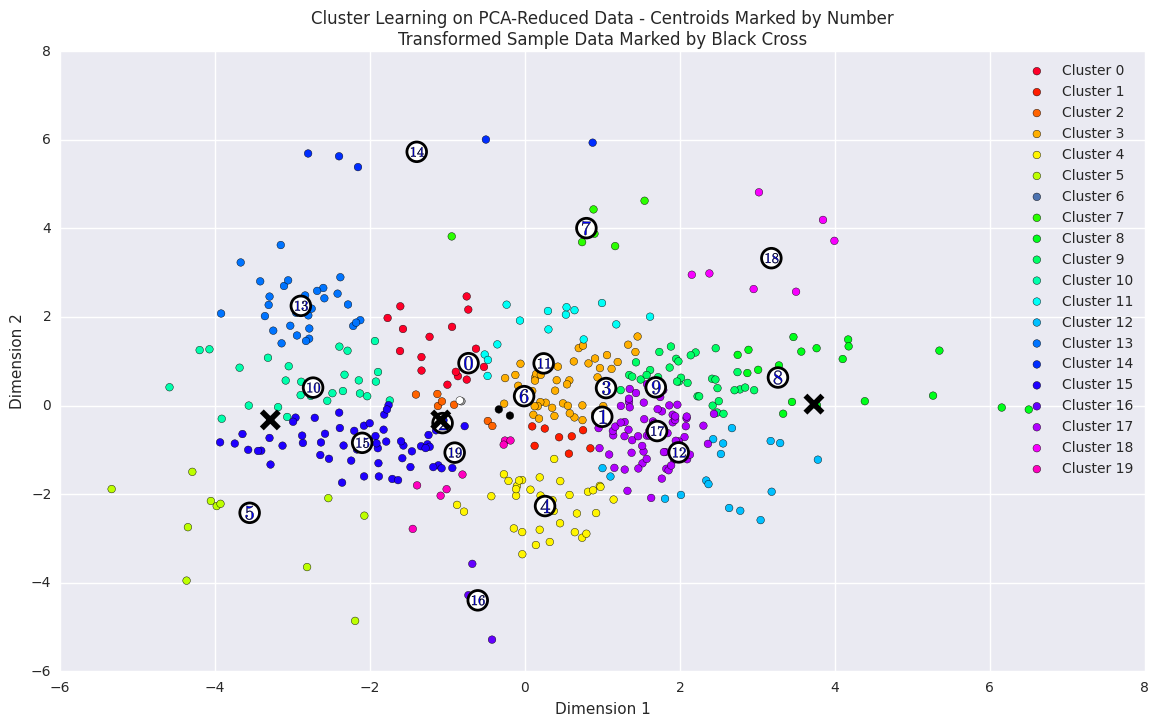

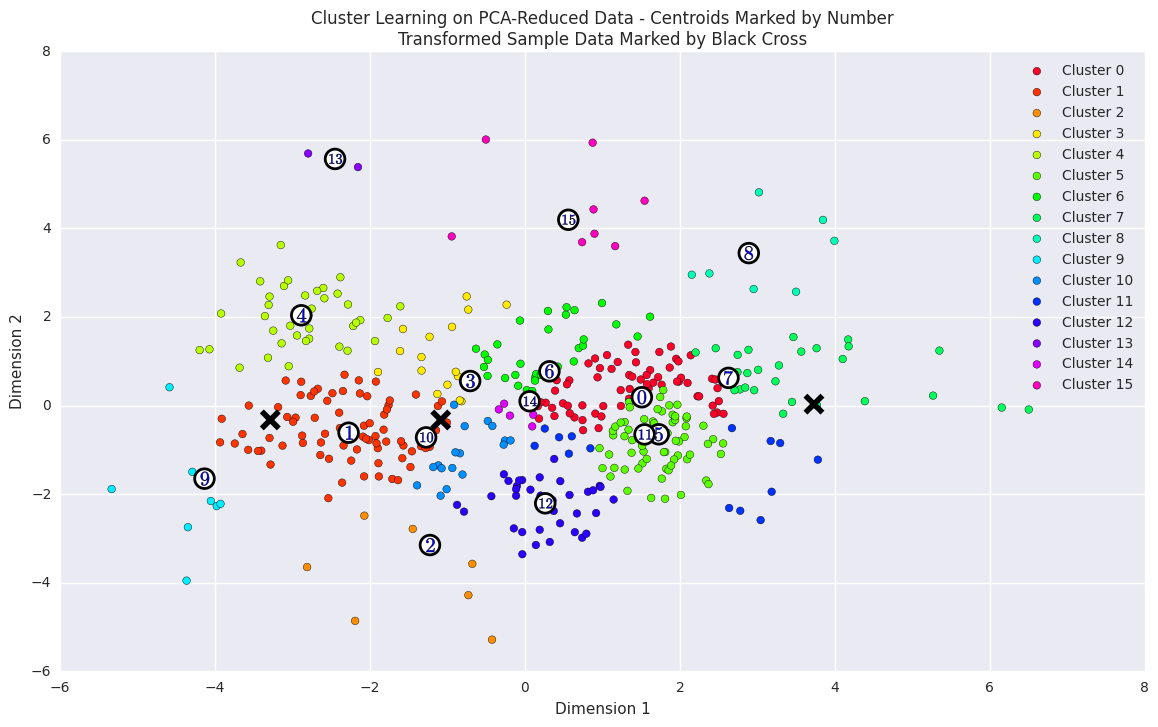

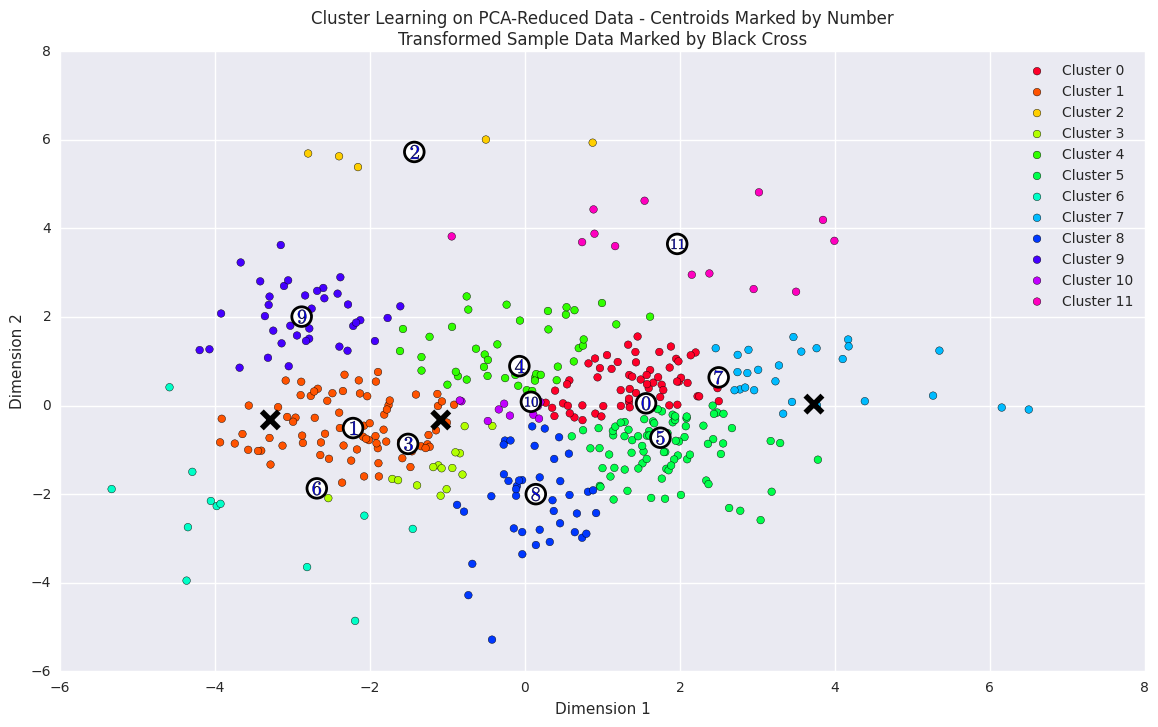

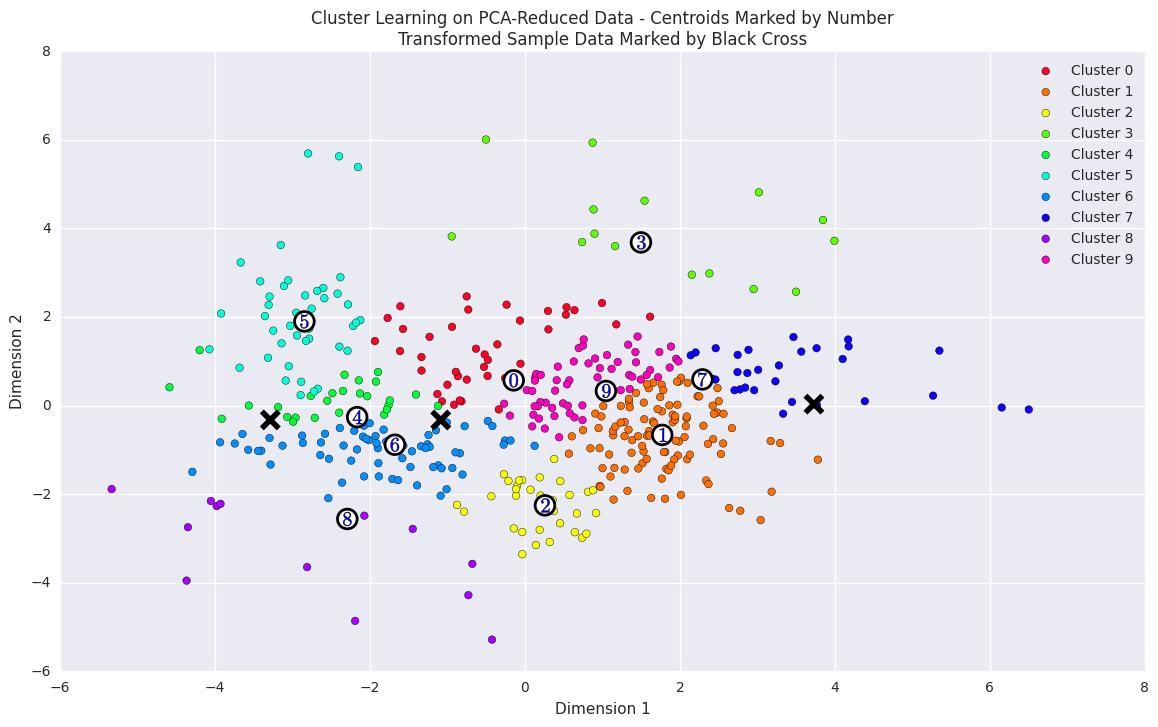

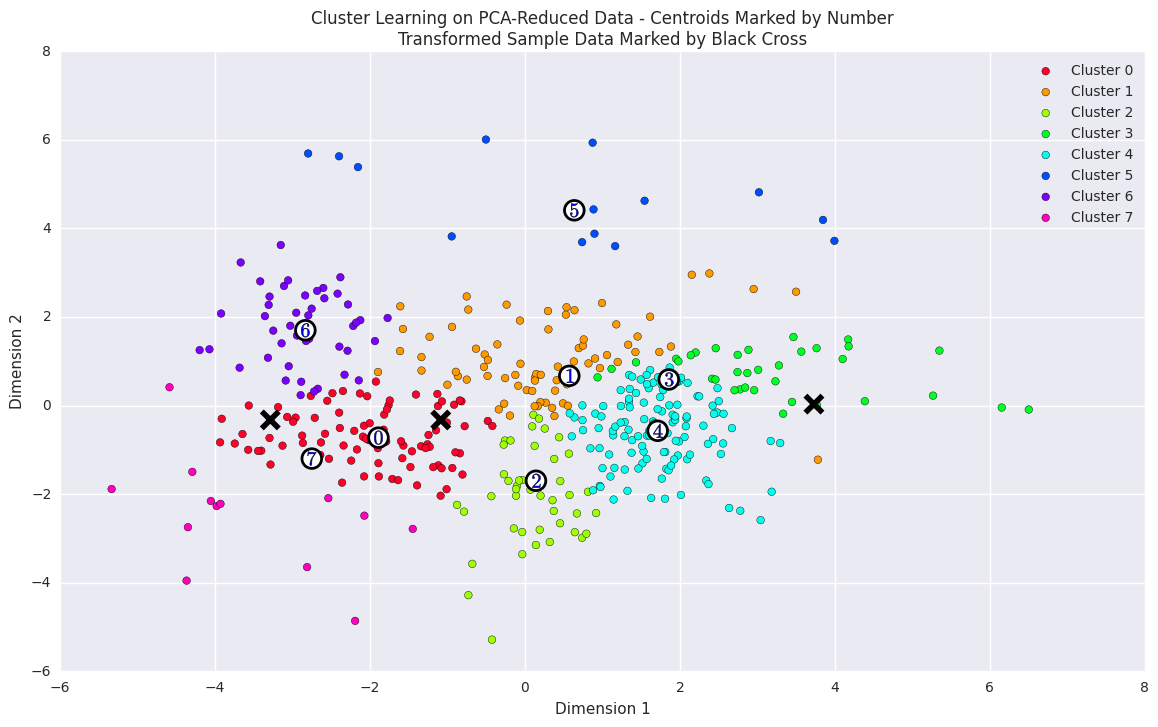

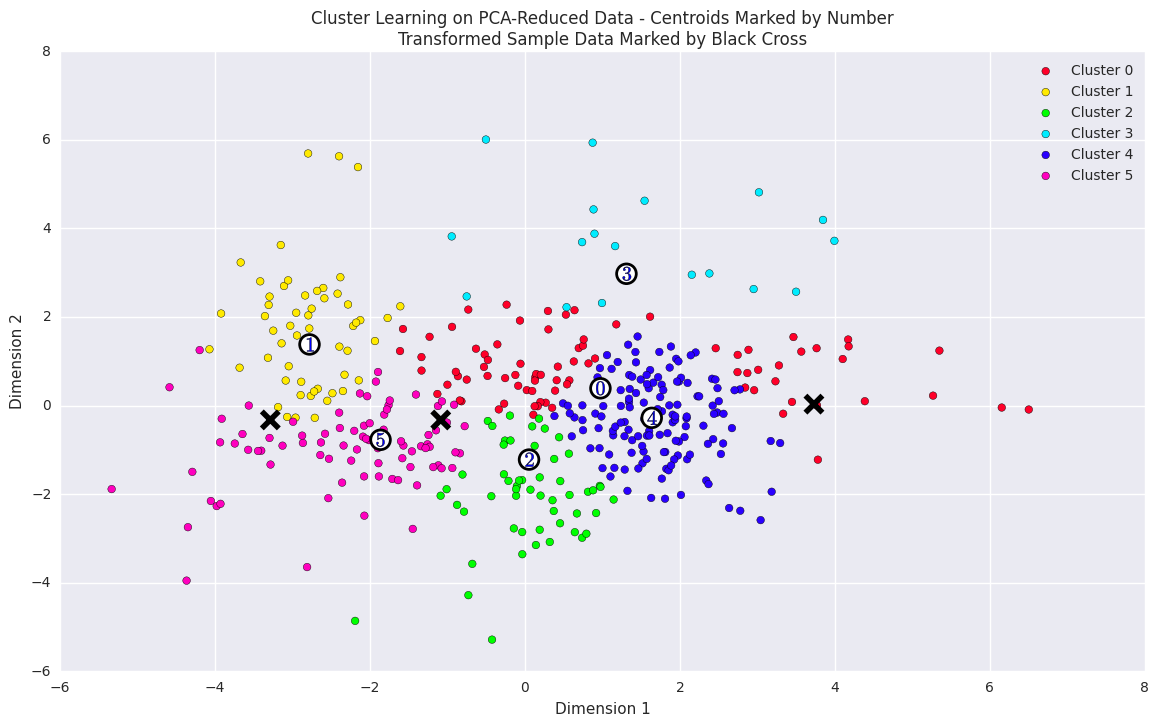

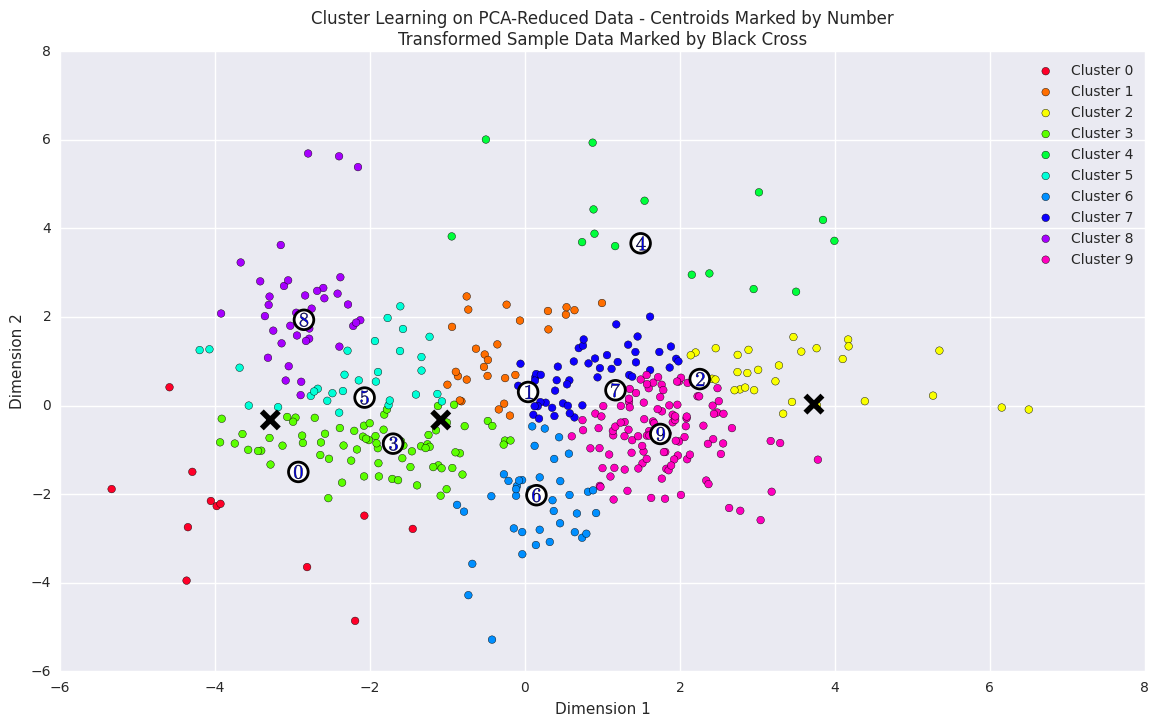

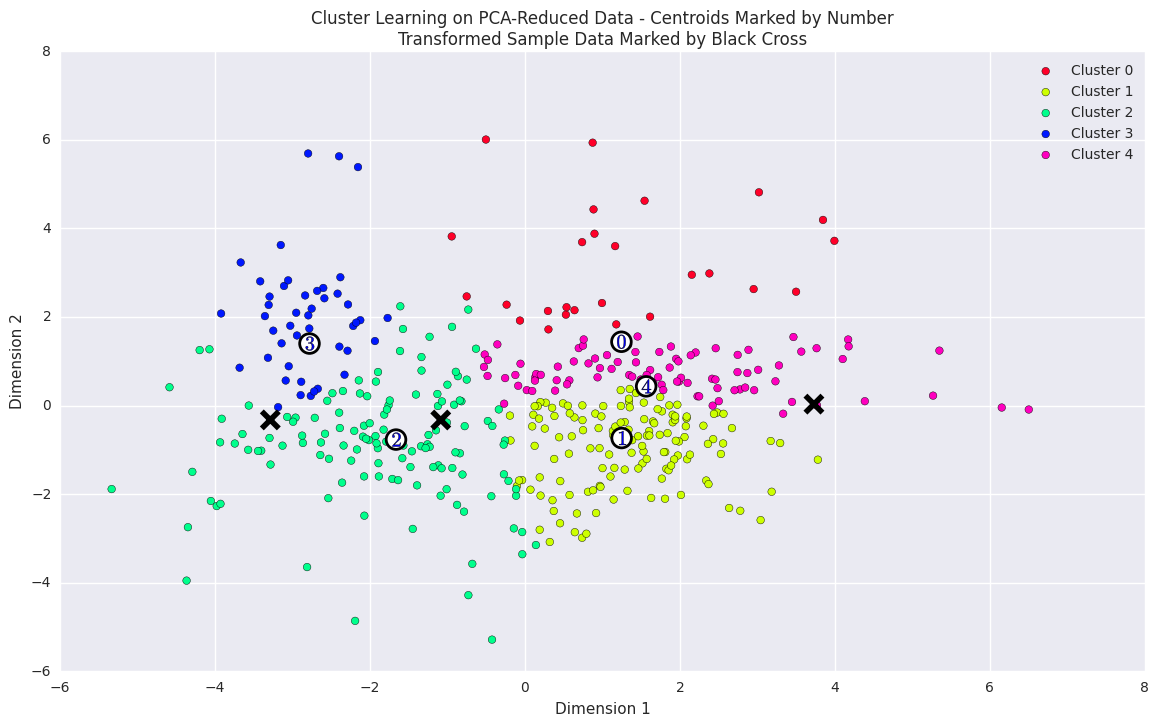

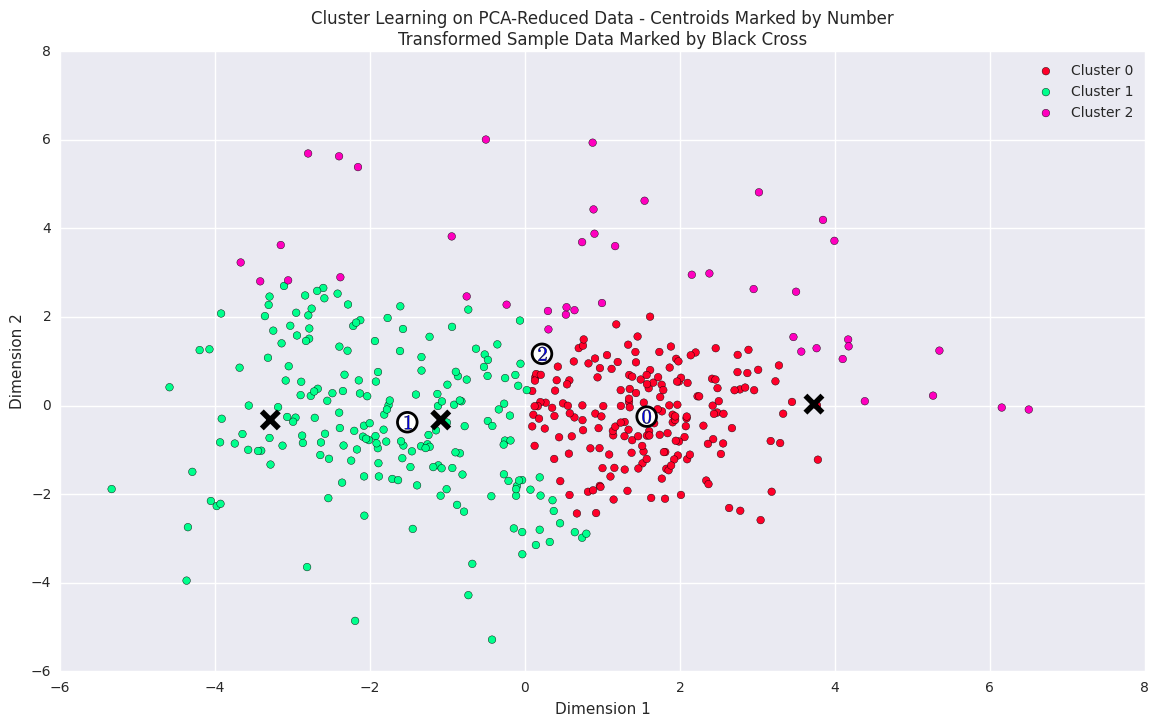

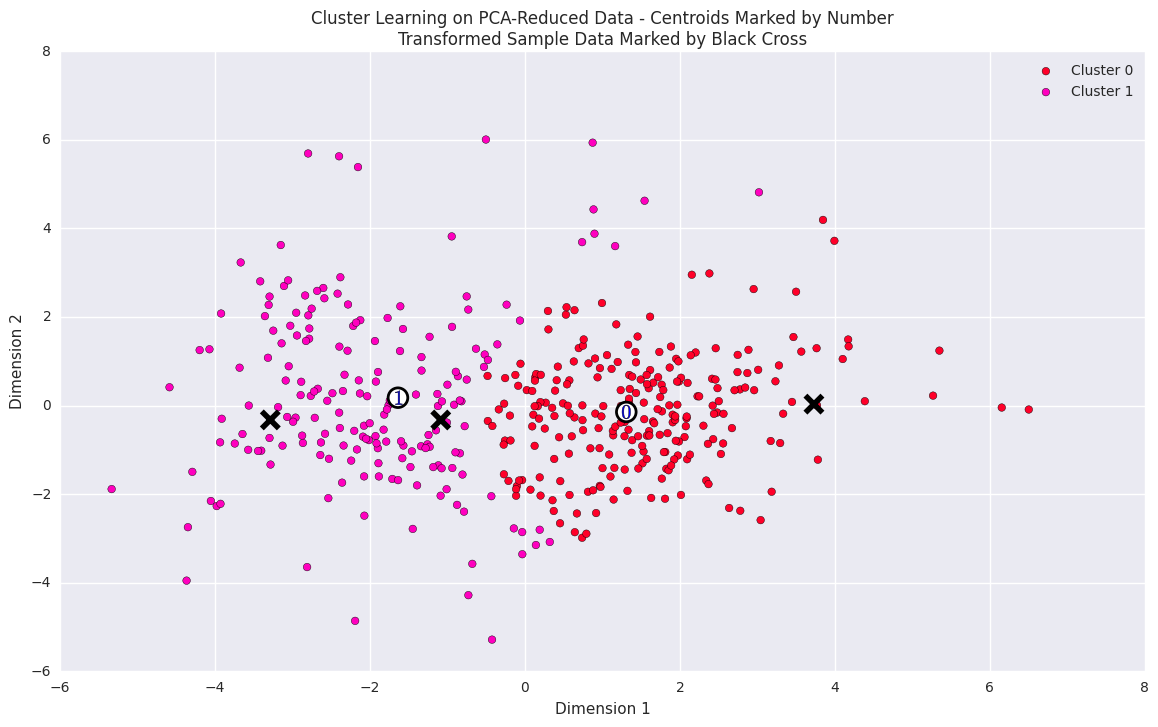

In [13]:
from sklearn import mixture
from sklearn.metrics import silhouette_score
# Apply your clustering algorithm of choice to the reduced data 
numClusters = [20,16,12,10,8,6,10,5,3,2]
for clusters in numClusters:
    clusterer = mixture.GMM(n_components=clusters)
    clusterer.fit(reduced_data)
    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)  # predict

    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds,random_state=1)
    print "Clusters: {},".format(clusters),"score: {}".format(score)
    rs.cluster_results(reduced_data, preds, centers, pca_samples)

**如上所示，我们可以看到，当选用2个聚类中心的时候，可以得到较好的分数，分数为0.411818864386。同时尝试了各种的聚类中心个数，比如2,3,4,5,6,8,10,12,16,20。得到的分数分别为：        
Clusters: 20, score: 0.207410457641    
Clusters: 16, score: 0.20493127684    
Clusters: 12, score: 0.282307732679    
Clusters: 10, score: 0.322029035516    
Clusters: 8, score: 0.304106857662    
Clusters: 6, score: 0.270498049376    
Clusters: 10, score: 0.275025255866    
Clusters: 5, score: 0.287010521606    
Clusters: 3, score: 0.371497053895    
Clusters: 2, score: 0.411818864386       
**

### Cluster Visualization
Once chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, we can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

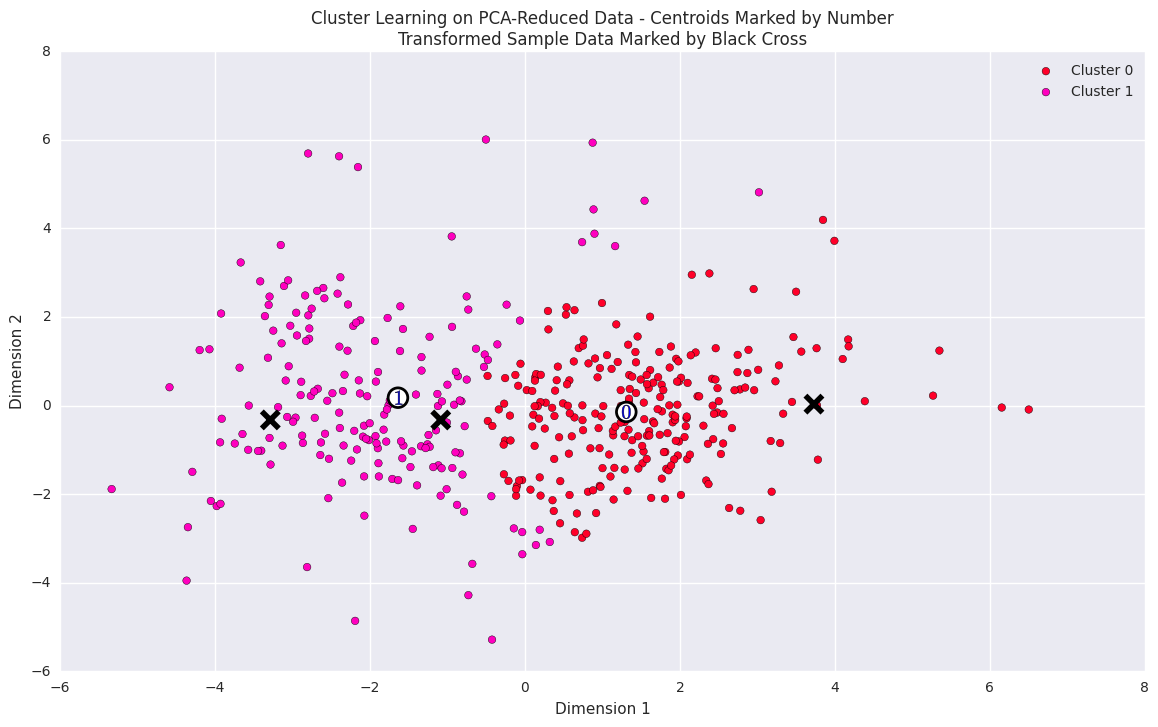

In [14]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery

In [15]:
# Inverse transform the centers
log_centers = pca.inverse_transform(clusterer.means_)

#  Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8812.0,2052.0,2689.0,2058.0,337.0,712.0
Segment 1,4316.0,6347.0,9555.0,1036.0,3046.0,945.0


 **Segment 0: 这一类别的顾客对于Grocery、Milk和Detergents_Paper的划分均高于平均数，而对于Fresh和Frozen的需求也低于平均水平。有可能代表的是普通杂货店和零售商。       
Segment 1: 我们可以看到，该类别的顾客对于租入Fresh，Milk，Grocery，Frozen等的各种类型的需求均低于平均值。我推测其可能是某个餐饮服务业，比如咖啡馆，餐厅等类型。**

In [16]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Sample point 0 和 Sample point 1 被预测为第一类普通零售商类。 而Sample point 0 和 Sample point 1被预测为餐饮服务类。这个预测我们之前的假设大致相同的。相对于餐饮服务类，大型超市类和零售商更加相近。因此这里把Sample point 0划分到普通零售商类别中。**

## Conclusion

### Visualizing Underlying Distributions

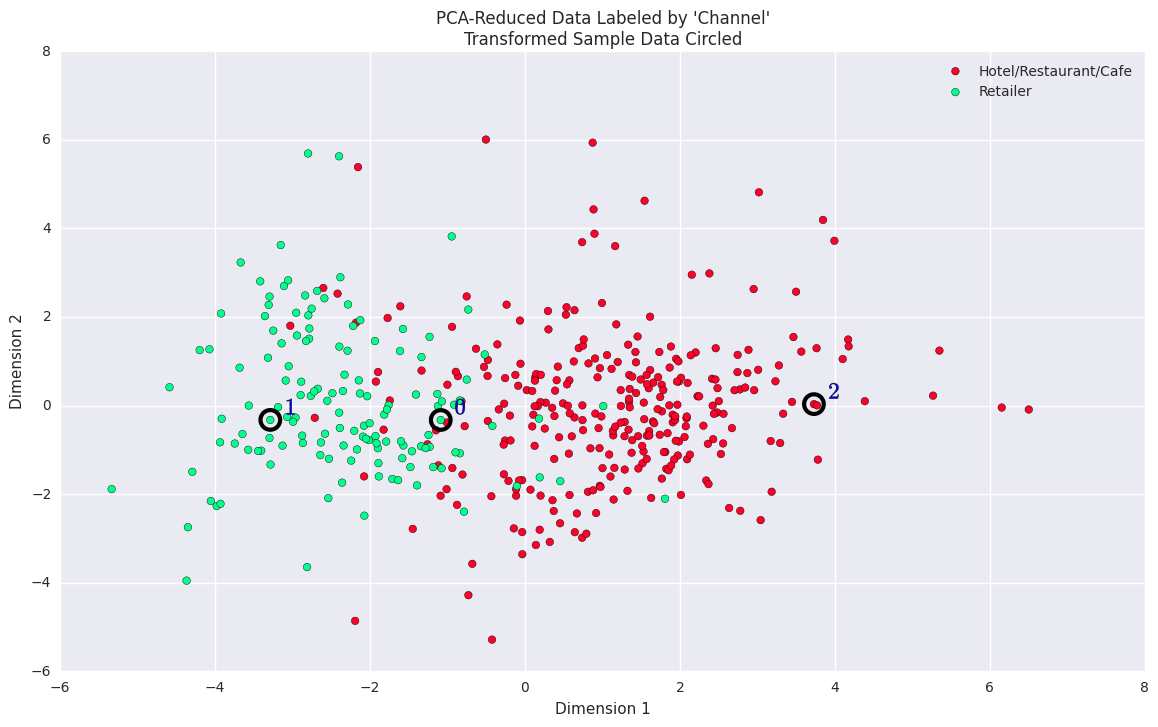

In [17]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

**聚类算法和聚类中心的选择需要根据不同的问题而定。以本题为例，就采样点0，它和和这两类均不相同，只是相比较于餐饮服务类，该样本点更接近于小型零售商类。所以被划分到了零售商类中。这个分类和之前对于客户的分类是基本一致的。**